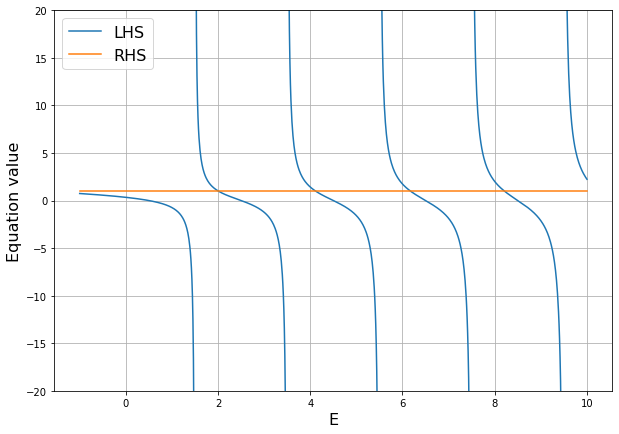

In [35]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ============================================
# Parameters
# ============================================

a = 1.0                     # interaction strength
rhs = 1.0 / a

mp.mp.dps = 30               # numerical precision

# ============================================
# Define functions
# ============================================

def lhs(E):
    return mp.gamma(-E/2 + mp.mpf(3)/4) / mp.gamma(-E/2 + mp.mpf(1)/4)

def f(E):
    return lhs(E) - rhs

# ============================================
# Plot of both sides (LHS and RHS)
# ============================================

E_plot = np.linspace(-1, 10, 1000)

# compute lhs safely and as floats
lhs_plot = []
for E in E_plot:
    try:
        lhs_plot.append(float(lhs(E)))
    except Exception:
        lhs_plot.append(np.nan)
lhs_plot = np.array(lhs_plot)

# break lines where there are very large jumps between adjacent points
diff = np.abs(np.diff(lhs_plot))
jump_thresh = 50.0
jump_idx = np.where(diff > jump_thresh)[0]
lhs_plot[jump_idx] = np.nan
lhs_plot[jump_idx + 1] = np.nan

rhs_plot = np.full_like(E_plot, rhs)

plt.figure(figsize=(10,7))
plt.plot(E_plot, lhs_plot, label="LHS")
plt.plot(E_plot, rhs_plot, label="RHS")
plt.ylim(-20, 20)
plt.xlabel("E", fontsize=16)
plt.ylabel("Equation value", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import mpmath as mp
from scipy.optimize import brentq

mp.mp.dps = 30

a = 1.0
rhs = 1.0 / a
Emin, Emax = -1, 10
eps = 1e-3

def lhs(E):
    return mp.gamma(-E/2 + mp.mpf(3)/4) / mp.gamma(-E/2 + mp.mpf(1)/4)

def f(E):
    return float(lhs(E) - rhs)

# ----- analytical poles: E = 2n + 3/2 -----
pole_roots = 2*np.arange(-10, 30) + 1.5
pole_roots = pole_roots[(pole_roots > Emin) & (pole_roots < Emax)]

E = np.linspace(Emin, Emax, 4000)

# safe evaluation excluding poles
fvals = []
for x in E:
    if np.any(np.abs(x - pole_roots) < eps):
        fvals.append(np.nan)
    else:
        try:
            fvals.append(f(x))
        except:
            fvals.append(np.nan)
fvals = np.array(fvals)

# Brent root finder
roots = []
for i in range(len(E)-1):
    if np.isfinite(fvals[i]) and np.isfinite(fvals[i+1]):
        if fvals[i] * fvals[i+1] < 0:
            # skip any interval touching a pole
            if np.any((pole_roots >= E[i]-eps) & (pole_roots <= E[i+1]+eps)):
                continue
            try:
                root = brentq(f, E[i], E[i+1])
                if not np.any(np.abs(root - pole_roots) < eps):
                    roots.append(root)
            except:
                pass

roots = np.unique(np.round(roots, 10))
print("Physical Busch solutions:")
print(roots)


Physical Busch solutions:
[2.00477559 4.11342516 6.1709676  8.2083255 ]


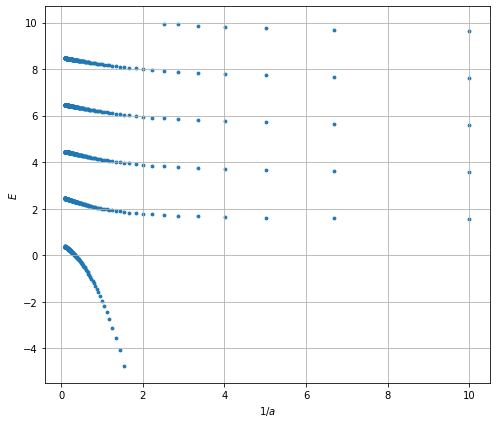

In [15]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import brentq

mp.mp.dps = 30  # numerical precision

def lhs(E):
    # use mpmath internally; E may be float
    E = mp.mpf(E)
    return mp.gamma(-E/2 + mp.mpf(3)/4) / mp.gamma(-E/2 + mp.mpf(1)/4)

# parameters for scanning
a_values = np.linspace(0.1, 10, 200)
inv_a_values = 1.0 / a_values
En_min, En_max = -5.0, 10.0
EnGrid = np.linspace(En_min, En_max, 4000)

# === compute analytical pole positions in the energy window ===
def compute_poles(En_min, En_max):
    poles_num = []  # numerator poles: E = 2m + 3/2 (1.5, 3.5, ...)
    poles_den = []  # denominator poles: E = 2n + 1/2 (0.5, 2.5, ...)
    # choose m,n range large enough to cover window
    m_min = int(np.floor((En_min - 1.5)/2.0)) - 1
    m_max = int(np.ceil((En_max - 1.5)/2.0)) + 1
    n_min = int(np.floor((En_min - 0.5)/2.0)) - 1
    n_max = int(np.ceil((En_max - 0.5)/2.0)) + 1

    for m in range(m_min, m_max+1):
        E = 2*m + 1.5
        if En_min <= E <= En_max:
            poles_num.append(E)
    for n in range(n_min, n_max+1):
        E = 2*n + 0.5
        if En_min <= E <= En_max:
            poles_den.append(E)
    return np.array(sorted(poles_num + poles_den))

poles = compute_poles(En_min, En_max)
# choose an exclusion radius (depends on grid spacing & desired safety)
exclusion_radius = 1e-2  # 0.01 energy units; increase if needed

# You can print poles to verify:
#print("Poles in range:", poles)

# storage for plotting
all_inv_a = []
all_E = []

for a, inva in zip(a_values, inv_a_values):
    rhs = inva
    # compute f on grid but mark as nan inside pole neighborhoods
    fGrid = np.empty_like(EnGrid)
    for i, E in enumerate(EnGrid):
        # if E is within exclusion_radius of a pole, mark as nan
        if np.any(np.abs(E - poles) < exclusion_radius):
            fGrid[i] = np.nan
            continue
        try:
            fGrid[i] = float(lhs(E) - rhs)
        except Exception:
            fGrid[i] = np.nan

    solutions = []
    # now bracket roots but skip intervals that intersect pole neighborhoods
    for i in range(len(EnGrid)-1):
        E1, E2 = EnGrid[i], EnGrid[i+1]
        # skip if either grid point is nan
        if not np.isfinite(fGrid[i]) or not np.isfinite(fGrid[i+1]):
            continue
        # also skip if the interval crosses any excluded pole neighborhood
        mid = 0.5*(E1 + E2)
        # if [E1,E2] intersects a neighborhood, skip
        if np.any((poles >= E1 - exclusion_radius) & (poles <= E2 + exclusion_radius)):
            continue
        f1, f2 = fGrid[i], fGrid[i+1]
        if f1 * f2 < 0:
            try:
                root = brentq(lambda x: float(lhs(x) - rhs), E1, E2, maxiter=200)
                # sanity: don't accept roots too close to a pole
                if np.any(np.abs(root - poles) < exclusion_radius):
                    continue
                solutions.append(root)
            except Exception:
                pass

    # deduplicate
    solutions = np.unique(np.round(solutions, 10))

    for E in solutions:
        all_inv_a.append(inva)
        all_E.append(E)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(all_inv_a, all_E, s=8)
plt.xlabel(r"$1/a$")
plt.ylabel(r"$E$")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import brentq

mp.mp.dps = 30  # numerical precision

def lhs(E):
    return mp.gamma(-E/2 + mp.mpf(3)/4) / mp.gamma(-E/2 + mp.mpf(1)/4)

# parameters for scanning
a_values = np.linspace(0.1, 10, 300)
inv_a_values = 1.0 / a_values
En_min, En_max = -5.0, 10.0
EnGrid = np.linspace(En_min, En_max, 4000)

# compute poles in window
def compute_poles(En_min, En_max):
    poles_num = []
    poles_den = []
    m_min = int(np.floor((En_min - 1.5)/2.0)) - 1
    m_max = int(np.ceil((En_max - 1.5)/2.0)) + 1
    n_min = int(np.floor((En_min - 0.5)/2.0)) - 1
    n_max = int(np.ceil((En_max - 0.5)/2.0)) + 1
    for m in range(m_min, m_max+1):
        E = 2*m + 1.5
        if En_min <= E <= En_max:
            poles_num.append(E)
    for n in range(n_min, n_max+1):
        E = 2*n + 0.5
        if En_min <= E <= En_max:
            poles_den.append(E)
    return np.array(sorted(poles_num + poles_den))

poles = compute_poles(En_min, En_max)
exclusion_radius = 0.05

# Track branches: list of lists, each sublist is [inv_a, E] pairs for one branch
branches = []

for a, inva in zip(a_values, inv_a_values):
    rhs = inva
    fGrid = np.empty_like(EnGrid)
    for i, E in enumerate(EnGrid):
        if np.any(np.abs(E - poles) < exclusion_radius):
            fGrid[i] = np.nan
            continue
        try:
            fGrid[i] = float(lhs(E) - rhs)
        except Exception:
            fGrid[i] = np.nan

    solutions = []
    for i in range(len(EnGrid)-1):
        E1, E2 = EnGrid[i], EnGrid[i+1]
        if not np.isfinite(fGrid[i]) or not np.isfinite(fGrid[i+1]):
            continue
        if np.any((poles >= E1 - exclusion_radius) & (poles <= E2 + exclusion_radius)):
            continue
        f1, f2 = fGrid[i], fGrid[i+1]
        if f1 * f2 < 0:
            try:
                root = brentq(lambda x: float(lhs(x) - rhs), E1, E2, maxiter=200)
                if np.any(np.abs(root - poles) < exclusion_radius):
                    continue
                solutions.append(root)
            except Exception:
                pass

    solutions = np.unique(np.round(solutions, 10))

    # Match each solution to an existing branch (by proximity) or start a new branch
    for E_sol in solutions:
        matched = False
        for branch in branches:
            last_E = branch[-1][1]
            # if within reasonable distance (0.5 energy units), add to this branch
            if abs(E_sol - last_E) < 0.5:
                branch.append([inva, E_sol])
                matched = True
                break
        if not matched:
            # Start a new branch
            branches.append([[inva, E_sol]])

# Plot
fig, ax = plt.subplots(figsize=(9, 7))

# Color palette for branches
colors = plt.cm.tab20(np.linspace(0, 1, len(branches)))

# Plot each branch as a line
for i, branch in enumerate(branches):
    if len(branch) > 1:  # only plot if we have multiple points
        branch = np.array(branch)
        ax.plot(branch[:, 0], branch[:, 1], color=colors[i], linewidth=2, label=f"Branch {i+1}")
    else:
        # single point, plot as scatter
        branch = np.array(branch)
        ax.scatter(branch[:, 0], branch[:, 1], color=colors[i], s=30, zorder=5)

ax.set_xlabel(r"$1/a$", fontsize=16)
ax.set_ylabel(r"$E$", fontsize=16)
#ax.set_title("Busch Spectrum (1D): Energy Branches vs $1/a$", fontsize=13)
ax.grid(True, alpha=0.3)
ax.set_ylim([En_min, En_max])
plt.tight_layout()
plt.show()